In [1]:
import pandas as pd
from utils.constants import Paths

In [2]:
user_df = pd.read_parquet(Paths.RAW_DATA_PARQUET / "user/pothole_311.parquet")

In [3]:
user_columns = [
    "Location",
    "Status",
    "Resolution Description",
    "Created Date",
    "Resolution Action Updated Date",
    "Street Name",
    "Cross Street 1",
    "Cross Street 2",
    "Intersection Street 1",
    "Intersection Street 2",
    "Address Type",
    "Incident Zip",
]

In [4]:
user_df = user_df[user_columns]

## Step 2: Processing Dataframe metadata

In [5]:
user_rename_map = {
    "Location": "geometry",
    "Status": "status",
    "Resolution Description": "resolution_description",
    "Created Date": "date_created",
    "Resolution Action Updated Date" : "date_closed",
    "Street Name": "street_name",
    "Cross Street 1": "cross_street_1",
    "Cross Street 2": "cross_street_2",
    "Intersection Street 1": "intersection_street_1",
    "Intersection Street 2": "intersection_street_2",
    "Address Type": "address_type",
    "Incident Zip": "zip_code",
}

user_df = user_df.rename(columns=user_rename_map)

In [6]:
user_df = user_df[~user_df['address_type'].isna()].dropna(subset=['geometry'])

In [7]:
user_df = user_df[user_df['status'] == "Closed"]
open_user_complaints = user_df[user_df['status'] != "Closed"]

user_df = user_df.drop(columns=["status"])

In [8]:
user_df['address_type'] = user_df['address_type'].replace('BLOCKFACE', 'ADDRESS')
user_df = user_df[user_df['address_type'] != 'PLACENAME']

Here we separate open and closed DataFrames, this is because the processing and grouping deals with response times

In [9]:
valid_complaint_strings = {
    "The Department of Transportation inspected this complaint and repaired the problem.",
    "The Department of Transportation has completed the request or corrected the condition.",
    "The Department of Transportation inspected the condition and temporary repairs were made to make the area safe. Permanent repairs/restoration will be scheduled as part of a project, seasonal work (April - November), or when work is assigned to a contractor.",
    "The Department of Transportation inspected this complaint and barricaded the area. The issue was referred to another unit for further action.",
}

In [10]:
user_df = user_df[user_df['resolution_description'].isin(valid_complaint_strings)]

In [11]:
import numpy as np

In [12]:
user_df = user_df[~((user_df['address_type'] == 'ADDRESS') & (user_df['cross_street_1'].isnull() | user_df['cross_street_2'].isnull()))]

In [13]:
user_df = user_df[~((user_df['address_type'] == 'INTERSECTION') & (user_df['intersection_street_1'].isnull() | user_df['intersection_street_2'].isnull()))]

In [14]:
address_mask_user = user_df['address_type'] == 'ADDRESS'
user_df.loc[address_mask_user, 'street'] = user_df.loc[address_mask_user, 'street_name'] + ', ' + user_df.loc[address_mask_user, ['cross_street_1', 'cross_street_2']].apply(sorted, axis=1).str.join(', ')

In [15]:
intersection_mask_user = user_df['address_type'] == 'INTERSECTION'
user_df.loc[intersection_mask_user, 'street'] = user_df.loc[intersection_mask_user, ['intersection_street_1', 'intersection_street_2']].apply(sorted, axis=1).str.join(', ')

In [16]:
user_df['date_created'] = pd.to_datetime(user_df['date_created'])
user_df['date_closed'] = pd.to_datetime(user_df['date_closed'])

In [17]:
user_df["response_time"] = np.where(
    user_df["resolution_description"].isin(valid_complaint_strings),
    (user_df["date_closed"] - user_df["date_created"]).dt.days,
    None,
)
user_df = user_df[user_df["response_time"] >= 0]

In [18]:
import geopandas as gpd
import ast
from shapely.geometry import Point

In [19]:
user_df = user_df.sort_values(['date_created','street'])
user_df['num_requests'] = 0


In [20]:
res_df = pd.DataFrame()

In [21]:
from pandas import Timedelta

In [ ]:
res_df = pd.DataFrame()
cnt = 0
for zip_code in user_df['zip_code'].unique():
    cnt += 1
    print(f"{cnt}/{len(user_df['zip_code'].unique())}")
    group = user_df[user_df['zip_code'] == zip_code]
    group = group.reset_index(drop=True)

    for i in range(len(group) - 1):
        if group.at[i, 'num_requests'] < 0:
            continue

        count = 0
        
        for j in range(i + 1, len(group)):
            if (group.iloc[j]['street'] == group.iloc[i]['street'] and
                group.iloc[j]['date_created'] <= (group.iloc[i]['date_closed'] + Timedelta(1, unit='D'))):
                count += 1
                group.at[j, 'num_requests'] = -1
            else:
                break
        group.at[i, 'num_requests'] = count
    
    res_df = pd.concat([res_df, group])

In [26]:
res_df['geometry'] = res_df['geometry'].apply(lambda loc: (lambda y, x: Point(x, y))(*ast.literal_eval(loc)))

In [27]:
res_gdf = gpd.GeoDataFrame(res_df, geometry='geometry', crs='EPSG:4326')

In [28]:
hexbin_plot_gdf = res_gdf.to_crs(epsg=3857)

In [30]:
import matplotlib.colors as colors

In [31]:
vmin, vmax = np.percentile(hexbin_plot_gdf['response_time'], [5, 95])
norm = colors.Normalize(vmin=vmin, vmax=vmax)

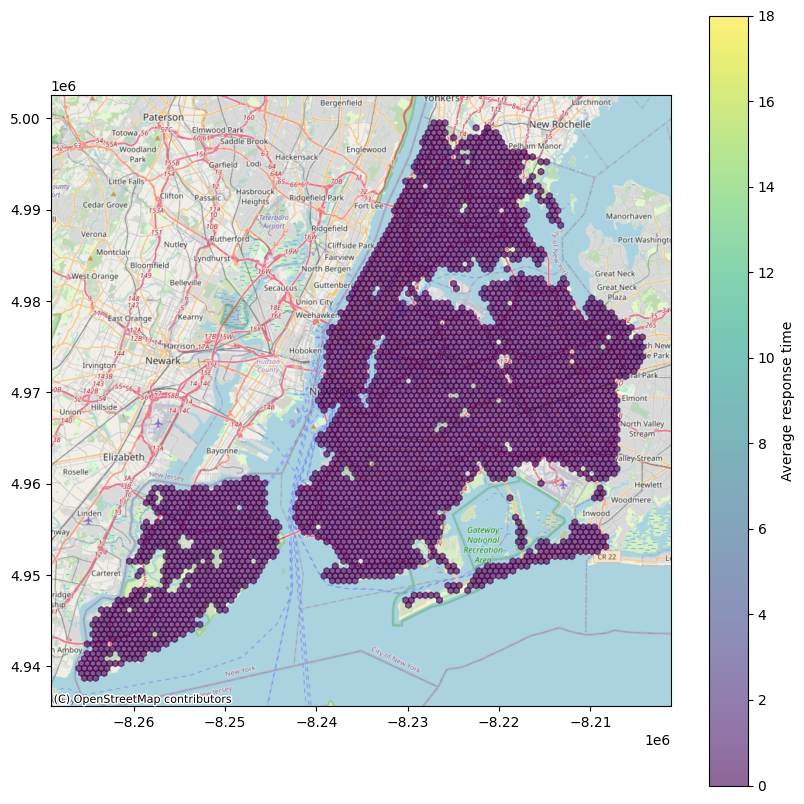

In [47]:
import contextily as ctx
import matplotlib.pyplot as plt

tile_provider = ctx.providers.OpenStreetMap.Mapnik

fig, ax = plt.subplots(figsize=(10, 10))


x = hexbin_plot_gdf.geometry.x
y = hexbin_plot_gdf.geometry.y

hb = ax.hexbin(x, y, C=hexbin_plot_gdf['num_requests'], gridsize=100, cmap='viridis', alpha=0.6, norm=norm)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Average response time')

# Add the basemap
ctx.add_basemap(ax, crs=hexbin_plot_gdf.crs.to_string(), source=tile_provider)

plt.show()

In [34]:
census_gdf = gpd.GeoDataFrame.from_file(str(Paths.RAW_DATA_CSV / "census_tracts.csv"))

In [35]:
from shapely import wkt

# Convert the string to a LineString
census_gdf['the_geom'] = census_gdf['the_geom'].apply(wkt.loads)
census_gdf = gpd.GeoDataFrame(census_gdf, geometry='the_geom', crs='EPSG:4326')

In [36]:
census_gdf = census_gdf[['the_geom', 'BoroCT2020', 'NTAName']]

In [38]:
# join results with census, the point in results_gdf needs to be within the_geom polygon in census_gdf, needs to be inner join
results_census_gdf = gpd.sjoin(res_gdf, census_gdf, how="inner", op='within')

/Users/DonGuest/Code/simcity-smart-cities/simcity_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3488: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [39]:
results_census_gdf = results_census_gdf.rename(columns={'BoroCT2020' : "bct_number","NTAName" : "neighborhood"})

In [40]:
results_census_gdf = results_census_gdf.drop(columns=['geometry', 'index_right'])

In [41]:
results_census_gdf.to_parquet(Paths.PROCESSED_DATA_PARQUET / "aggregated_pothole.parquet")

In [42]:
from tabulate import tabulate

In [44]:
print(tabulate(results_census_gdf.sort_values(by="num_requests",ascending=False).head(15), headers='keys', tablefmt="psql", showindex=False))

+-------------------------------------------------------------------------------------+---------------------+---------------------+---------------------+------------------+------------------+-------------------------+-------------------------+----------------+------------+----------------------------------------------------+-----------------+----------------+--------------+----------------------------------------------+
| resolution_description                                                              | date_created        | date_closed         | street_name         | cross_street_1   | cross_street_2   | intersection_street_1   | intersection_street_2   | address_type   |   zip_code | street                                             |   response_time |   num_requests |   bct_number | neighborhood                                 |
|-------------------------------------------------------------------------------------+---------------------+---------------------+---------------------

In [59]:
new_df = results_census_gdf.copy()
new_df['num_requests'] = new_df['num_requests'].replace(-1, 1)

In [60]:
# aggregate results_census_gdf by neighborhood, and apply mean to response_time and num_requests
neighborhood_gdf = new_df.groupby('neighborhood').agg({'response_time': 'mean', 'num_requests': 'mean'}).reset_index()

In [61]:
neighborhood_gdf.sort_values(by="num_requests",ascending=False).head(15)

,neighborhood,response_time,num_requests
125,John F. Kennedy International Airport,3.266667,0.160000
132,LaGuardia Airport,3.214286,0.142857
175,Pelham Bay Park,5.077128,0.127660
142,Marine Park-Plumb Island,4.310559,0.118012
7,Astoria Park,0.727273,0.090909
233,University Heights (South)-Morris Heights,4.150976,0.087256
86,Fort Hamilton,4.0,0.080000
37,Central Park,3.340886,0.077240
256,Yankee Stadium-Macombs Dam Park,1.606557,0.073770
173,Park Slope,3.863073,0.068966
